# HR Data

### Quelles data ?
- **Compétence**
- **Performance**
- **Reward**
- **Core Employee Data** Age, Experience

### Macro-objectifs d'usages Data
1. Optimisation des Ressources Humaines :
    - Alignement stratégique entre compétences individuelles et besoins métiers.
    - Identification des surcapacités/déficits de compétences par département.
    - Détection de talents cachés (employés sous-utilisés).
2. Gestion Prédictive des Talents :
    - Anticipation des départs (analyse de turnover) via les patterns de compétences.
    - Préparation de plans de succession basés sur les profils similaires.
3. Efficacité Opérationnelle :
    - Affectation optimale des employés aux projets selon leurs forces.
4. Réduction des Risques :
    - Détection des dépendances critiques (ex : compétences rares concentrées chez peu d’employés).

### Autre cas d'usage concret

| Application                     | Méthodes DS                        | 
|---------------------------------|------------------------------------|
| Clustering de compétences       | K-means, DBSCAN                    |
| Skill Gap Analysis              | Analyse de variance, PCA           |
| Simulation de réorganisations   | Agent-Based Modeling               |
| Compensation explicative        | SHAP                               |

________
## Création du dataset

In [474]:
import pandas as pd # type: ignore
import numpy as np # type: ignore
import matplotlib.pyplot as plt # type: ignore
import seaborn as sns # type: ignore
import shap # type: ignore
shap.initjs()

from sklearn.model_selection import train_test_split, cross_val_predict # type: ignore
from sklearn.preprocessing import StandardScaler # type: ignore
from sklearn.cluster import KMeans # type: ignore
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score # type: ignore
from sklearn.svm import SVC # type: ignore
from sklearn.neighbors import KNeighborsClassifier # type: ignore
from sklearn.ensemble import IsolationForest, RandomForestClassifier    # type: ignore
from sklearn.metrics.pairwise import cosine_similarity  # type: ignore
from sklearn.linear_model import LinearRegression # type: ignore

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [475]:
# Définition du nombre d'employés
n_employees = 1000
np.random.seed(42)
departments = ['CPL', 'OPS', 'IT']
skills = ['LAW', 'CUSTODY', 'FUNDS', 'PROJET', 'TECHNICAL']
ids = ['E' + str(i).zfill(5) for i in range(1, n_employees + 1)]

dept_distribution = np.random.choice(
    departments, 
    size=n_employees,
    p=[0.10, 0.55, 0.35]  # Probabilités ajustées pour 1000 employés
)

df = pd.DataFrame({
    'ID': ids,
    'Dpt': dept_distribution
})

skill_profiles = {
    'CPL': {
        'LAW': [0.00, 0.00, 0.70, 0.30],  # 70% de niveau 2, 30% de niveau 3
        'CUSTODY': [0.85, 0.10, 0.05, 0.00],  # 85% de niveau 0, 10% de niveau 1
        'FUNDS': [0.85, 0.10, 0.05, 0.00],  # 85% de niveau 0, 10% de niveau 1
        'PROJET': [0.85, 0.10, 0.05, 0.00],  # 85% de niveau 0, 10% de niveau 1
        'TECHNICAL': [0.85, 0.10, 0.05, 0.00]   # 85% de niveau 0, 10% de niveau 1
    },
    'OPS': {
        'LAW': [0.80, 0.15, 0.05, 0.00],  # 80% de niveau 0, 15% de niveau 1
        'CUSTODY': [0.00, 0.50, 0.40, 0.10],  # 50% de niveau 1, 40% de niveau 2
        'FUNDS': [0.00, 0.20, 0.70, 0.10],  # 20% de niveau 1, 70% de niveau 2
        'PROJET': [0.95, 0.05, 0.00, 0.00],  # 95% de niveau 0, 5% de niveau 1
        'TECHNICAL': [0.90, 0.05, 0.05, 0.00]   # 90% de niveau 0, 5% de niveau 1
    },
    'IT': {
        'LAW': [0.90, 0.05, 0.05, 0.00],  # 90% de niveau 0, 5% de niveau 1
        'CUSTODY': [1.00, 0.00, 0.00, 0.00],  # 100% de niveau 0
        'FUNDS': [0.50, 0.30, 0.20, 0.00],  # 50% de niveau 0, 30% de niveau 1
        'PROJET': [0.00, 0.00, 0.70, 0.30],  # 70% de niveau 2, 30% de niveau 3
        'TECHNICAL': [0.00, 0.00, 0.00, 1.00]   # 100% de niveau 3
    }}

# Génération des compétences
for skill in skills:
    df[skill] = 0  # Initialisation

for idx, row in df.iterrows():
    dept = row['Dpt']
    profile = skill_profiles[dept]
    
    for skill in skills:
        probs = profile[skill]
        df.at[idx, skill] = np.random.choice([0, 1, 2, 3], p=probs)

# Réorganisation des colonnes
df = df[['ID', 'Dpt'] + skills]

# Création des anomalies
anomalies = pd.DataFrame({
    'ID': ['E90001', 'E90002', 'E90003', 'E90004', 'E90005'],
    'Dpt': ['CPL', 'OPS', 'IT', 'CPL', 'OPS'],
    'LAW': [0, 0, 2, 2, 0],
    'CUSTODY': [0, 1, 3, 0, 2],
    'FUNDS': [0, 2, 1, 0, 2],
    'PROJET': [1, 2, 2, 3, 3],
    'TECHNICAL': [1, 0, 0, 3, 0]
})

# Ajout des anomalies au DataFrame existant
df = pd.concat([df, anomalies], ignore_index=True)

In [476]:
df.head()

,ID,Dpt,LAW,CUSTODY,FUNDS,PROJET,TECHNICAL
0,E00001,OPS,0,2,2,0,0
1,E00002,IT,0,0,2,2,3
2,E00003,IT,0,0,2,2,3
3,E00004,OPS,1,1,2,0,0
4,E00005,OPS,0,1,3,1,1


In [477]:
df.groupby('Dpt')[skills].mean().round(2)

,LAW,CUSTODY,FUNDS,PROJET,TECHNICAL
Dpt,,,,,
CPL,2.25,0.18,0.25,0.24,0.26
IT,0.15,0.01,0.70,2.29,2.99
OPS,0.24,1.64,1.87,0.07,0.15


# Clustering
Le modèle peut identifier les structures sous-jacente des département sur la base des seules compétences.

In [453]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[['LAW', 'CUSTODY', 'FUNDS', 'PROJET', 'TECHNICAL']])
y = df['Dpt']

# Diviser les données en échantillons d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Entrainer le modèle K-means
kmeans = KMeans(n_clusters=3)
kmeans.fit(X_train)

# Prédire les départements à partir des compétences
y_pred = kmeans.predict(X_test)
df['y_pred'] = kmeans.predict(X_scaled)

In [454]:
conf_mat_not_mapped = pd.crosstab(
    df['Dpt'],
    df['y_pred'],
    rownames=['Vraies valeurs'],
    colnames=['Prédictions'])
cluster_to_dpt = conf_mat_not_mapped.idxmax(axis=0).to_dict()
df['Dpt_pred'] = df['y_pred'].map(cluster_to_dpt)

conf_mat = pd.crosstab(
    df['Dpt'],
    df['Dpt_pred'],
    rownames=['Vraies valeurs'],
    colnames=['Prédictions'], margins=True)
conf_mat

Prédictions,CPL,IT,OPS,All
Vraies valeurs,,,,
CPL,108,2,0,110
IT,0,329,1,330
OPS,15,1,549,565
All,123,332,550,1005


# Classification
Le modèle apprend les rélations entre compétences et départment (variable à expliquer)

In [455]:
# Appliquer plusieurs modèles de classification
models = {
    'Forêt aléatoire': RandomForestClassifier(),
    'SVM': SVC(),
    'K-NN': KNeighborsClassifier()
}

In [456]:
for nom, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"Model : {nom} Accuracy - {accuracy_score(y_test, y_pred):.2f}%")
    # print(confusion_matrix(y_test, y_pred))
    # print("======== \n")

Model : Forêt aléatoire Accuracy - 1.00%
Model : SVM Accuracy - 1.00%
Model : K-NN Accuracy - 1.00%


# Outliers
Le modèle va identifier les employés dont les compétence sont statistiquement anormales.

In [457]:
departments = df['Dpt'].unique()
outliers = pd.DataFrame()

model = IsolationForest(
    contamination=0.05,
    random_state=42)

# 2. Détection d'anomalies par département
for dept in departments:
    dept_data = df[df['Dpt'] == dept].copy()
    X = dept_data[['LAW', 'CUSTODY', 'FUNDS', 'PROJET', 'TECHNICAL']]
    scaler = StandardScaler()
    X_scaled_temp = scaler.fit_transform(X)
    model.fit(X_scaled_temp)
    dept_data['outlier'] = model.predict(X_scaled_temp)
    outliers = pd.concat([outliers, dept_data[dept_data['outlier'] == -1]])

# 3. Analyse des résultats
print("📊 Anomalies détectées par département :")
outliers.groupby('Dpt').size()

📊 Anomalies détectées par département :


Dpt
CPL     6
IT     16
OPS    29
dtype: int64

In [458]:
print(f"🔍 Total d'anomalies détectées: {len(outliers)}. Exemples:")
outliers.sample(5, random_state=42)

🔍 Total d'anomalies détectées: 51. Exemples:


,ID,Dpt,LAW,CUSTODY,FUNDS,PROJET,TECHNICAL,y_pred,Dpt_pred,outlier
966,E00967,IT,2,0,2,2,3,1,IT,-1
763,E00764,IT,1,0,2,3,3,1,IT,-1
285,E00286,CPL,3,0,2,0,1,2,CPL,-1
415,E00416,OPS,1,3,1,0,1,0,OPS,-1
824,E00825,OPS,0,3,1,0,1,0,OPS,-1


# Modèle de Recommandations

In [459]:
# Features et Target
X = df[skills]
y = df['Dpt']

# Définition des compétences minimales (exemple simplifié)
skill_requirements = {
    'CPL': {'LAW': 2, 'CUSTODY': 0, 'FUNDS': 0, 'PROJET': 0, 'TECHNICAL': 0},
    'OPS': {'CUSTODY': 1, 'FUNDS': 1, 'PROJET': 0, 'TECHNICAL': 0},
    'IT': {'PROJET': 2, 'TECHNICAL': 3}
}

# Modèle avec probabilités
model = RandomForestClassifier()
model.fit(X, y)  # Fit the model to get the classes
predicted_probas = cross_val_predict(model, X, y, method='predict_proba', cv=5)

threshold = 0.5  # Seuil de probabilité pour recommander un transfert

# 3. Recommandation de Transferts (version améliorée avec compétences)
recommendations = []
for idx, row in df.iterrows():
    current_dept = row['Dpt']
    probas = predicted_probas[idx]
    
    for dept, prob in zip(model.classes_, probas):
        if dept != current_dept and prob > threshold:
            # Vérification des compétences requises
            meets_requirements = all(
                row[skill] >= skill_requirements[dept].get(skill, 0)
                for skill in skills)
            
            if meets_requirements:
                # Création d'un dictionnaire avec toutes les infos
                recommendation = {
                    'ID': row['ID'],
                    'Current_Dpt': current_dept,
                    'Suggested_Dpt': dept,
                    'Probability': round(prob, 2),
                    'Reason': 'Compétences adéquates',
                    # Ajout des compétences
                    'LAW': row['LAW'],
                    'CUSTODY': row['CUSTODY'],
                    'FUNDS': row['FUNDS'],
                    'PROJET': row['PROJET'],
                    'TECHNICAL': row['TECHNICAL']
                }
                recommendations.append(recommendation)

# Conversion en DataFrame
rec_df = pd.DataFrame(recommendations).sort_values('Probability', ascending=False)

In [460]:
# Affichage avec les compétences
print("🔍 Exemple de recommandations avec compétences :")
rec_df

🔍 Exemple de recommandations avec compétences :


,ID,Current_Dpt,Suggested_Dpt,Probability,Reason,LAW,CUSTODY,FUNDS,PROJET,TECHNICAL
4,E90004,CPL,IT,1.00,Compétences adéquates,2,0,0,3,3
2,E00834,OPS,CPL,0.90,Compétences adéquates,2,1,1,0,0
1,E00595,IT,CPL,0.67,Compétences adéquates,2,0,0,3,3
3,E90003,IT,OPS,0.64,Compétences adéquates,2,3,1,2,0
0,E00440,CPL,OPS,0.54,Compétences adéquates,2,1,1,0,0


In [461]:
# Vérification des anomalies
anomaly_ids = ['E90001', 'E90002', 'E90003', 'E90004', 'E90005']
print("\n🔍 Anomalies dans les recommandations :")
rec_df[rec_df['ID'].isin(anomaly_ids)]


🔍 Anomalies dans les recommandations :


,ID,Current_Dpt,Suggested_Dpt,Probability,Reason,LAW,CUSTODY,FUNDS,PROJET,TECHNICAL
4,E90004,CPL,IT,1.00,Compétences adéquates,2,0,0,3,3
3,E90003,IT,OPS,0.64,Compétences adéquates,2,3,1,2,0


# Modèle de recommandations (similarité cosinus)


In [462]:
# Calculer le profil moyen de compétences par département
dept_profiles = df.groupby('Dpt')[skills].mean().reset_index()
# Créer une matrice des compétences des employés
employee_skills = df[skills].values
# Créer une matrice des profils départementaux
dept_skills = dept_profiles[skills].values

In [463]:
# Calculer la similarité cosinus entre chaque employé et chaque département
similarity_matrix = cosine_similarity(employee_skills, dept_skills)

# Convertir en DataFrame
similarity_df = pd.DataFrame(
    similarity_matrix,
    index=df['ID'],
    columns=dept_profiles['Dpt']
)

In [464]:
recommendations = []
threshold = 0.7  # Seuil de similarité minimal

for idx, row in similarity_df.iterrows():
    current_dept = df.loc[df['ID'] == idx, 'Dpt'].values[0]
    sorted_depts = row.sort_values(ascending=False).index
    
    for dept in sorted_depts:
        if dept != current_dept and row[dept] > threshold:
            recommendations.append({
                'ID': idx,
                'Current_Dpt': current_dept,
                'Suggested_Dpt': dept,
                'Similarity_Score': round(row[dept], 2),
                **df[df['ID'] == idx][skills].iloc[0].to_dict()
            })
            break  # On garde seulement la meilleure recommandation

rec_df_cos = pd.DataFrame(recommendations)
rec_df_cos.head()

,ID,Current_Dpt,Suggested_Dpt,Similarity_Score,LAW,CUSTODY,FUNDS,PROJET,TECHNICAL
0,E00015,OPS,IT,0.71,0,1,1,0,2
1,E00037,OPS,CPL,0.75,2,1,2,0,0
2,E00045,OPS,CPL,0.75,2,1,2,0,0
3,E00067,OPS,IT,0.70,0,2,2,1,2
4,E00144,OPS,CPL,0.74,2,1,2,1,0


## Reward

In [465]:
np.random.seed(42)  # Pour la reproductibilité
n_employees = 10_000  # Nombre d'employés

# Génération des données
performance = np.random.randint(0, 6, size=n_employees)  # Performance de 0 à 5
seniority = np.random.choice(['junior', 'senior'], size=n_employees, p=[0.6, 0.4])  # 60% junior, 40% senior
classic_skills = np.random.randint(1, 5, size=n_employees)  # Nombre de compétences classiques (1 à 10)
advanced_skills = np.random.randint(0, 2, size=n_employees)  # Nombre de compétences de pointe (0 à 5)

# Calcul du salaire en fonction des autres variables
base_salary = 30_000  # Salaire de base
salary = np.round((
    base_salary
    + performance * 2_000  # Impact de la performance
    + (seniority == 'senior') * 5_000  # Impact de l'ancienneté
    + classic_skills * 1_500  # Impact des compétences classiques
    + advanced_skills * 15_000  # Impact des compétences de pointe
    + np.random.normal(0, 2_000, size=n_employees)  # Bruit aléatoire
), -2)

# Création du DataFrame
data = pd.DataFrame({
    'Performance': performance,
    'Seniority': seniority,
    'Skills': classic_skills,
    'Top Skills': advanced_skills,
    'Salary': salary
})

data.head()

,Performance,Seniority,Skills,Top Skills,Salary
0,3,junior,4,1,56600.0
1,4,junior,3,0,44500.0
2,2,junior,1,1,47100.0
3,4,junior,2,1,54500.0
4,4,junior,4,0,44300.0


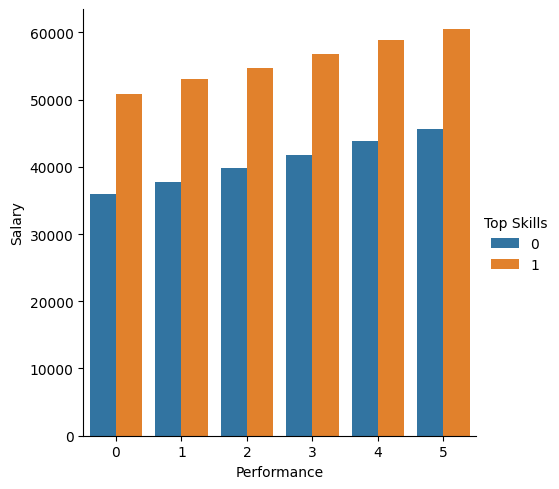

In [466]:
sns.catplot(x='Performance', y='Salary', data=data, hue='Top Skills', ci=None, kind='bar')
plt.show()


In [467]:
pd.DataFrame(data["Salary"].describe())

,Salary
count,10000.000000
mean,48097.090000
std,8942.832323
min,26700.000000
25%,40600.000000
50%,47900.000000
75%,55700.000000
max,71000.000000


In [468]:
# Encodage des variables catégorielles
data['Seniority'] = data['Seniority'].map({'junior': 0, 'senior': 1})

# Séparation des features et de la target
X = data.drop(columns=['Salary'])
y = data['Salary']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) # Séparation en train et test

# Utiliser un modèle de régression linéaire
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
y_pred_linear = linear_model.predict(X_test)
residuals = np.abs(y_test - y_pred_linear)
results = X_test.copy()
results['True Salary'] = y_test
results['Predicted Salary'] = np.round(y_pred_linear,0)
results['Residuals'] = np.round(residuals,-1)

# Trier par résidus (les plus faibles en premier)
results_sorted = results.sort_values(by='Residuals', ascending=False)

# Afficher les 5 employés avec les meilleures prédictions
top_5_employees = results_sorted.head(5)
top_5_employees

,Performance,Seniority,Skills,Top Skills,True Salary,Predicted Salary,Residuals
6475,2,0,1,1,44200.0,50577.0,6380.0
9083,1,0,4,1,46700.0,53044.0,6340.0
9420,5,1,4,0,44600.0,50904.0,6300.0
2474,5,0,1,0,35200.0,41468.0,6270.0
4638,2,1,4,1,66200.0,60012.0,6190.0


Erreur quadratique moyenne (Régression linéaire) : 3847361.0
Coefficient de détermination (Régression linéaire) : 0.9531644187158441


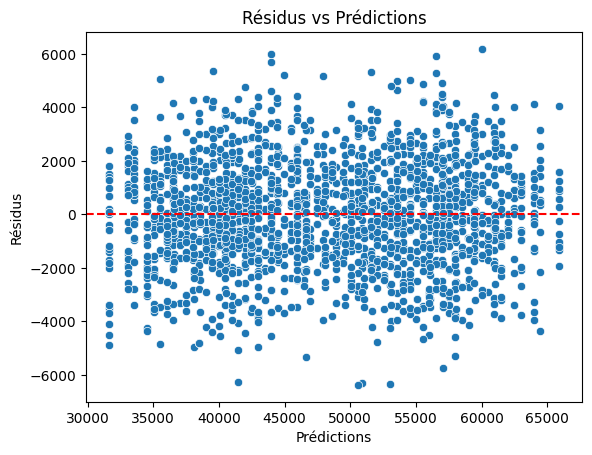

In [469]:
mse_linear = np.round(mean_squared_error(y_test, y_pred_linear),0)
print(f'Erreur quadratique moyenne (Régression linéaire) : {mse_linear}')
r2 = r2_score(y_test, y_pred_linear)
print(f'Coefficient de détermination (Régression linéaire) : {r2}')

# Calcul des résidus # Tracer les résidus
residuals = np.round(y_test - y_pred_linear,0)
sns.scatterplot(x=y_pred_linear, y=residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Résidus vs Prédictions')
plt.xlabel('Prédictions')
plt.ylabel('Résidus')
plt.show()

### SHAP

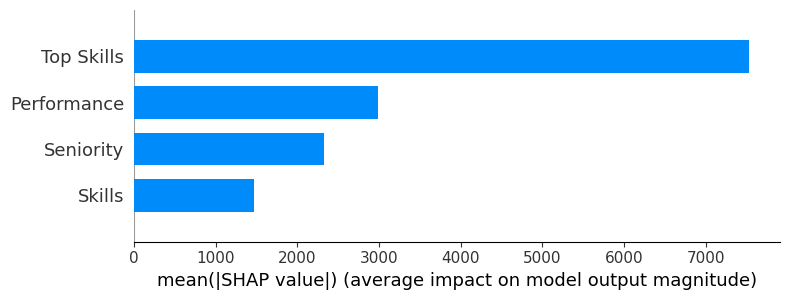

In [470]:
# SHAP Explainer
explainer = shap.LinearExplainer(linear_model, X_train)
shap_values = explainer.shap_values(X_test)
# Résumé des valeurs SHAP pour toutes les instances
shap.summary_plot(shap_values, X_test, plot_type="bar")

In [471]:
index_to_explain = 1  # Index de l'employé à expliquer
print(f"Vrai salaire : {y_test.iloc[index_to_explain]:.2f}")
print(f"Prédiction du salaire : {linear_model.predict(X_test.iloc[[index_to_explain]])[0]:.2f}")

Vrai salaire : 41600.00
Prédiction du salaire : 41467.74


In [472]:
shap.force_plot(
    explainer.expected_value,  # Valeur moyenne des prédictions
    shap_values[index_to_explain, :],  # SHAP values pour cette observation
    X_test.iloc[index_to_explain, :],  # Valeurs des caractéristiques pour cette observation
    feature_names=X.columns  # Noms des caractéristiques
)

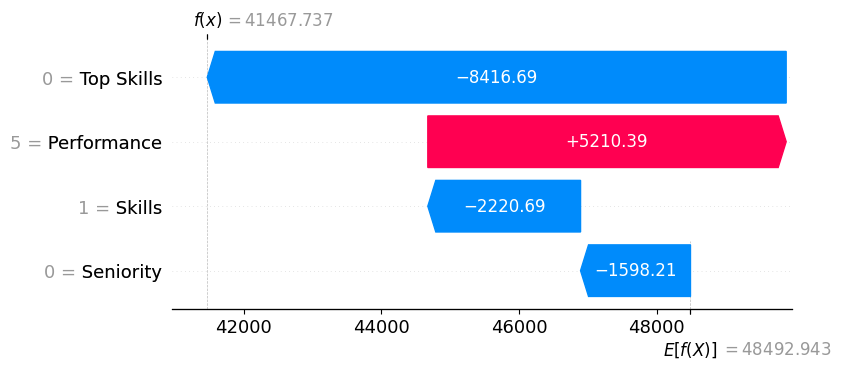

In [473]:
# Convert shap_values to a shap.Explanation object
shap_explanation = shap.Explanation(values=shap_values[index_to_explain, :], base_values=explainer.expected_value, data=X_test.iloc[index_to_explain, :])
shap.plots.waterfall(shap_explanation)

# test

In [35]:
import pandas as pd
import numpy as np
import json

# Charger les scénarios à partir d'un fichier JSON
with open("https://raw.githubusercontent.com/levmanuel/HR-Data/main/scenarios.json", "r") as f:
    scenarios = json.load(f)

# Chargement du fichier CSV
df = pd.read_csv("https://raw.githubusercontent.com/levmanuel/HR-Data/main/profiles.csv")

FileNotFoundError: [Errno 2] No such file or directory: 'https://raw.githubusercontent.com/levmanuel/HR-Data/main/scenarios.json'

In [ ]:
scenarios

In [32]:
# Définir la liste des compétences (colonnes à traiter)
skills = df.columns[1:]

# Générer 1 000 lignes aléatoires en répétant les données du CSV existant
expanded_df = pd.DataFrame(np.tile(df.values, (1000 // len(df) + 1, 1)), columns=df.columns)
df = expanded_df.iloc[:1000]  # Prendre seulement 1000 lignes

# Pour chaque employé, pour chaque compétence, générer un niveau selon le scénario
results = []  # Pour stocker les résultats
for idx, row in df.iterrows():
    employee_result = {'Dpt': row['Dpt']}
    for skill in skills:
        # Récupérer le code scénario (en s'assurant de le convertir en entier)
        scenario_code = int(row[skill]) if pd.notna(row[skill]) else 0
        # Récupérer la distribution de probabilités correspondante
        probabilities = scenarios.get(scenario_code, [1.0, 0.0, 0.0, 0.0])
        # Générer le niveau de compétence
        level = np.random.choice([0, 1, 2, 3], p=probabilities)
        employee_result[skill] = level
    results.append(employee_result)

# Créer un DataFrame avec les niveaux générés
df_generated = pd.DataFrame(results)

In [33]:
df_generated

,Dpt,LAW,CUSTODY,FUNDS,PROJET,TECHNICAL
0,CPL,2,0,0,0,0
1,OPS,0,2,3,0,0
2,IT,0,0,0,2,3
3,CPL,3,0,0,0,0
4,OPS,0,3,2,0,0
...,...,...,...,...,...,...
995,IT,0,0,0,2,2
996,CPL,3,0,0,0,0
997,OPS,0,2,2,0,0
998,IT,0,0,0,2,2
